In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load Data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

### Helper functions

In [12]:
def plot_history(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


In [6]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# plot predictions and return a merged dataframe of all the predictions against the actual values
def plot_predictions(predictions, actual):
    pred_df = pd.DataFrame()
    pred_df['Actual'] = actual
    try:
        plt.figure(figsize=(12, 8))
        for idx, prediction in enumerate(predictions):
            plt.plot(prediction, label=f'Prediction-{idx+1}')
            pred_df[f'Prediction-{idx+1}'] = prediction
    except ValueError as e:
        print('Error:', e)

    print(pred_df)
    plt.plot(actual, label='Actual')
    plt.legend()
    plt.show()

    return pred_df

In [11]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'minmax': minmax})


In [22]:
def inverse_transform(X, scaler):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), 15))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:,0]

## Data preprocessing and preparation


In [3]:
from sklearn.preprocessing import MinMaxScaler

In [55]:
# CONsTS
dataset = df.values  # get raw values from dataframe
TIMESTEPS = 30
TRAIN_SIZE = int(len(dataset) * 0.75)  # 75% training set
TEST_SIZE = len(dataset) - TRAIN_SIZE  # 25% test set
FEATURES = 14  # number of features

In [56]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train, test = dataset[:TRAIN_SIZE, :], dataset[TRAIN_SIZE:len(dataset), :]

# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, TIMESTEPS)
testX, testY = create_dataset(test, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], TIMESTEPS, FEATURES))
testX = np.reshape(testX, (testX.shape[0], TIMESTEPS, FEATURES))

In [57]:
# Input shape for LSTM
input = (trainX.shape[1], trainX.shape[2])
input

(30, 14)

## Build and fit model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                20224     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
26/26 [==============================] - 1s 45ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 2/20
26/26 [==============================] - 0s 18ms/step - loss: 3.6257e-04 - val_loss: 6.6904e-04
Epoch 3/20
26/26 [==============================] - 1s 20ms/step - loss: 2.7608e-04 - val_loss: 5.4907e-04
Epoch 4/20
26/26 [==============================] - 1s 21ms/step - loss: 2.6453e-04 - val_loss: 4.7535e-04
Epoch 5/20
26/26 [==============================] - 1s 21ms/step - loss: 2.3150e-04 - val_lo

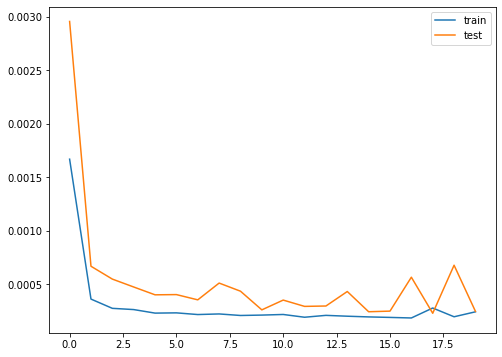

In [27]:
# model1
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=input))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
history = model.fit(trainX, trainY, validation_split=0.4, epochs=20, batch_size=32)

plot_history(history)

{'mape': '29.106%', 'me': -13404.03017452224, 'mae': 13500.248632366214, 'mpe': -0.28484140923271023, 'rmse': 15050.003868280512, 'corr': 0.9537962290995516, 'minmax': 0.28928877861073177}
           Actual  Prediction-1
0    13765.144079  12631.820302
1    13573.000000  12768.391692
2    14025.929379  12903.281486
3    14163.302878  12763.197652
4    15605.181292  13213.065128
..            ...           ...
421  50696.802160  34268.878121
422  47535.309698  34199.950634
423  46471.230000  34249.411420
424  47128.468155  34080.483753
425  46208.210437  33748.735892

[426 rows x 2 columns]


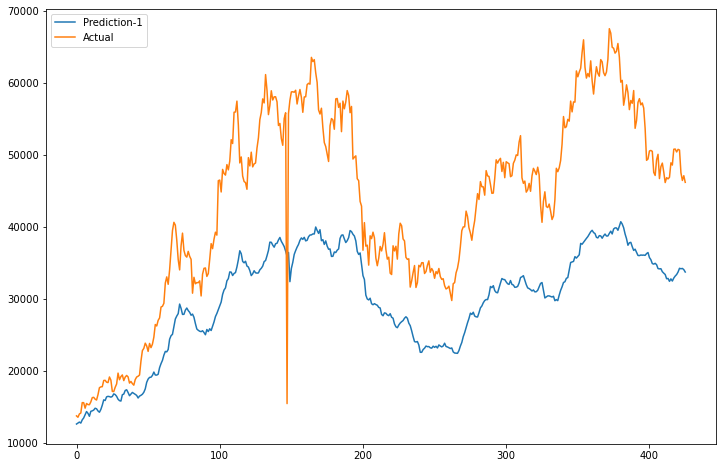

In [37]:
# make predictions: model 1
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverse transform predictions
inv_train_yhat = inverse_transform(trainPredict, scaler)
inv_test_yhat = inverse_transform(testPredict, scaler)
test_period = df[-len(inv_test_yhat):].close.values

# accuracy metrics
print(forecast_accuracy(inv_test_yhat, test_period))

# plot predictions
predictions = plot_predictions([inv_test_yhat], test_period)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 128)           73216     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

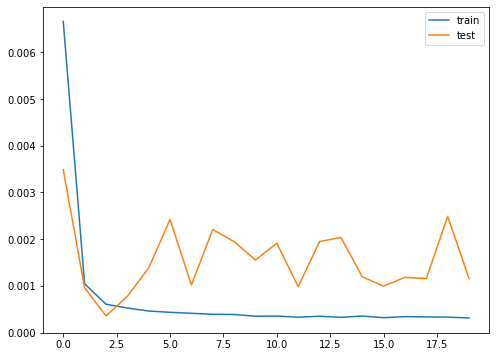

In [38]:
# model2
model2 = Sequential()
model2.add(LSTM(units=128, activation='tanh', return_sequences=True,
                input_shape=input))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, activation='tanh', return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=128, activation='tanh', return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))  # Prediction of the next value

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.summary()

history2 = model2.fit(trainX, trainY, validation_split=0.3, epochs=20, batch_size=64)
plot_history(history2)

           Actual  Prediction-1  Prediction-2
0    13765.144079  12631.820302  15262.909611
1    13573.000000  12768.391692  15251.154366
2    14025.929379  12903.281486  15224.923473
3    14163.302878  12763.197652  15163.574109
4    15605.181292  13213.065128  15170.949246
..            ...           ...           ...
421  50696.802160  34268.878121  34213.228270
422  47535.309698  34199.950634  34254.788544
423  46471.230000  34249.411420  34320.937917
424  47128.468155  34080.483753  34410.613700
425  46208.210437  33748.735892  34521.682556

[426 rows x 3 columns]


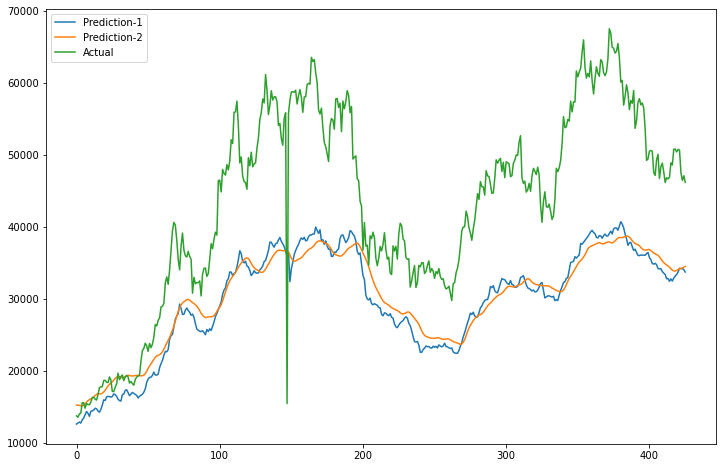

,Actual,Prediction-1,Prediction-2
0,13765.144079,12631.820302,15262.909611
1,13573.000000,12768.391692,15251.154366
2,14025.929379,12903.281486,15224.923473
3,14163.302878,12763.197652,15163.574109
4,15605.181292,13213.065128,15170.949246
...,...,...,...
421,50696.802160,34268.878121,34213.228270
422,47535.309698,34199.950634,34254.788544
423,46471.230000,34249.411420,34320.937917
424,47128.468155,34080.483753,34410.613700


In [42]:
# make predictions
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

# inverse
inv_train_yhat2 = inverse_transform(trainPredict2, scaler)
inv_test_yhat2 = inverse_transform(testPredict2, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2], df[-len(inv_test_yhat):].close.values)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
42/42 [==============================] - 2s 41ms/step - loss: 0.0058 - val_loss: 0.1006
Epoch 2/20
42/42 [==============================] - 1s 16ms/step - loss: 6.9914e-04 - val_loss: 0.0736
Epoch 3/20
42/42 [==============================] - 1s 16ms/step - loss: 4.0821e-04 - val_loss: 0.0618
Epoch 4/20
42/42 [==============================] - 1s 16ms/step - loss: 3.2913e-04 - val_loss: 0.0468
Epoch 5/20
42/42 [==============================] - 1s 18ms/step - loss: 3.1206e-04 - val_loss: 0.0418
E

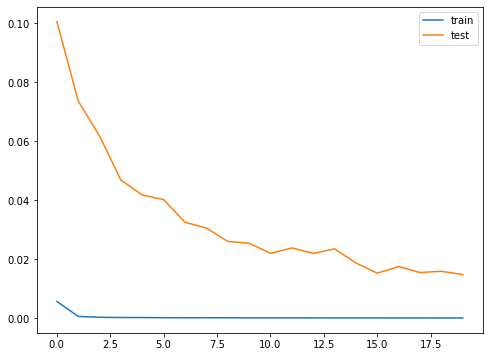

In [59]:
# model3: with validation input
model3 = Sequential()

model3.add(LSTM(50, activation='tanh', input_shape=input))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()
history3 = model3.fit(trainX, trainY, validation_data=(testX, testY), epochs=20, batch_size=32)

plot_history(history3)

           Actual  Prediction-1  Prediction-2  Prediction-3
0    13765.144079  12631.820302  15262.909611  12471.533446
1    13573.000000  12768.391692  15251.154366  12442.657772
2    14025.929379  12903.281486  15224.923473  12535.699731
3    14163.302878  12763.197652  15163.574109  12648.119833
4    15605.181292  13213.065128  15170.949246  13058.325546
..            ...           ...           ...           ...
421  50696.802160  34268.878121  34213.228270  42558.887061
422  47535.309698  34199.950634  34254.788544  42086.671286
423  46471.230000  34249.411420  34320.937917  42248.406900
424  47128.468155  34080.483753  34410.613700  41675.856617
425  46208.210437  33748.735892  34521.682556  41298.693750

[426 rows x 4 columns]


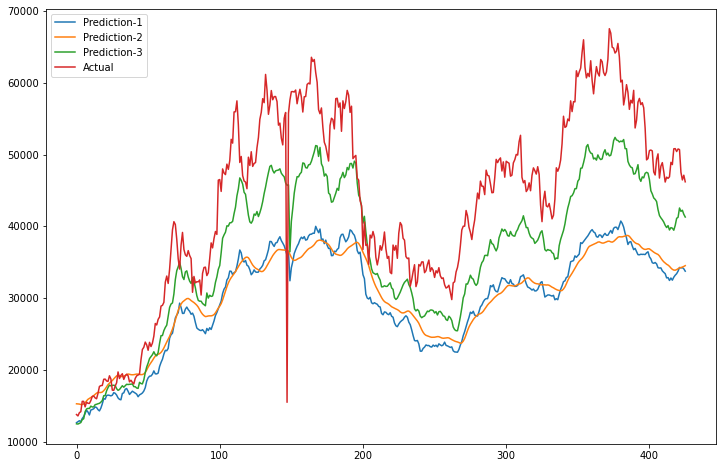

,Actual,Prediction-1,Prediction-2,Prediction-3
0,13765.144079,12631.820302,15262.909611,12471.533446
1,13573.000000,12768.391692,15251.154366,12442.657772
2,14025.929379,12903.281486,15224.923473,12535.699731
3,14163.302878,12763.197652,15163.574109,12648.119833
4,15605.181292,13213.065128,15170.949246,13058.325546
...,...,...,...,...
421,50696.802160,34268.878121,34213.228270,42558.887061
422,47535.309698,34199.950634,34254.788544,42086.671286
423,46471.230000,34249.411420,34320.937917,42248.406900
424,47128.468155,34080.483753,34410.613700,41675.856617


In [60]:
# make predictions
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

# inverse
inv_train_yhat3 = inverse_transform(trainPredict3, scaler)
inv_test_yhat3 = inverse_transform(testPredict3, scaler)

#plot
plot_predictions([inv_test_yhat, inv_test_yhat2, inv_test_yhat3], df[-len(inv_test_yhat):].close.values)

In [61]:
# accuracy comparisons
def pprint(d):
    for key, value in d.items():
        print(f"\t{key}: {value}")


print("Model 1:")
pprint(forecast_accuracy(inv_test_yhat, df[-len(inv_test_yhat):].close.values))
print("Model 2:")
pprint(forecast_accuracy(inv_test_yhat2,
                         df[-len(inv_test_yhat2):].close.values))
print("Model 3:")
pprint(forecast_accuracy(inv_test_yhat3,
                         df[-len(inv_test_yhat3):].close.values))


Model 1:
	mape: 29.106%
	me: -13404.03017452224
	mae: 13500.248632366214
	mpe: -0.28484140923271023
	rmse: 15050.003868280512
	corr: 0.9537962290995516
	minmax: 0.28928877861073177
Model 2:
	mape: 27.266%
	me: -12920.758630561595
	mae: 13116.90618211259
	mpe: -0.26028374974494356
	rmse: 15208.707339312634
	corr: 0.9183569725241469
	minmax: 0.2706204873635908
Model 3:
	mape: 15.68%
	me: -6920.022773399842
	mae: 7121.029220971642
	mpe: -0.14575336766519506
	rmse: 8324.933808726808
	corr: 0.9562298402459583
	minmax: 0.15371033013832913
